In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [2]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
type(train_images)

numpy.ndarray

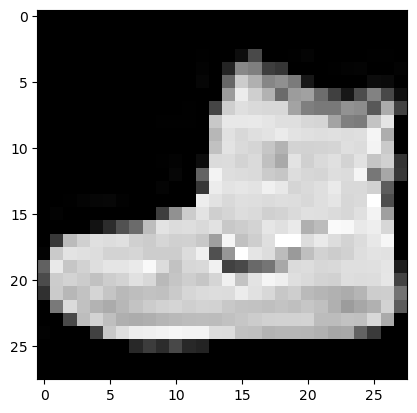

In [5]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()
     

In [6]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  
     

(60000, 28, 28)
(60000, 28, 28, 1)


In [7]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [8]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [9]:
# build the generator model
generator = build_generator() 


generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      51

C:\ProgramData\miniconda3\envs\cvpra\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model
     

# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 
     

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

In [11]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [25]:
import matplotlib.pyplot as plt

# Define a function to visualize filters
def visualize_filters(model, title_prefix, n_filters=6):
    for layer in model.layers:
        # Check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # Get filter weights
        filters, biases = layer.get_weights()
        
        # Skip layers with only one channel
        if filters.shape[-1] == 1:
            continue

        print(layer.name, filters.shape)

        # Visualize filters in each convolutional layer
        ix = 1
        for i in range(min(n_filters, filters.shape[-1])):
            # Get the filter
            f = filters[:, :, :, i]
            
            # Check the shape of the filter
            if len(f.shape) > 2:
                # Plot each channel separately
                for j in range(min(3, f.shape[-1])):
                    # Specify subplot and turn off axis
                    ax = plt.subplot(n_filters, 3, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    
                    # Plot filter channel in grayscale
                    ax.imshow(f[:, :, j], cmap='gray')
                    ix += 1
            else:
                # If the filter is 1D, skip plotting
                continue

        # Show the figure for each layer
        plt.suptitle(f'{title_prefix} - {layer.name}')
        plt.show()


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, discriminator=None, generator=None):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.discriminator = discriminator
        self.generator = generator

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

        # Build the discriminator model with convolutional layers only
        discriminator_conv_layers = discriminator.layers[:-2]  # Exclude Flatten and Dropout layers
        self.discriminator_conv_model = Sequential(discriminator_conv_layers)

        # Build the generator model with convolutional layers
        generator_conv_layers = generator.layers[:5]  # Extract convolutional layers
        self.generator_conv_model = Sequential(generator_conv_layers)

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        # Visualize the activations in the generator's convolutional layers
        self.visualize_generator_activations(epoch)

        # Visualize the activations in the discriminator's convolutional layers
        self.visualize_discriminator_activations(epoch)

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def visualize_generator_activations(self, epoch):
        # Choose an input noise (replace 'path_to_input_noise' with the actual path)
        input_noise = tf.random.normal([1, self.latent_dim])
        input_noise = tf.expand_dims(input_noise, axis=0)

        # Ensure input_noise has the correct shape (batch_size, latent_dim)
        input_noise = tf.squeeze(input_noise, axis=1)

        # Get activations from the generator's convolutional layers
        activations = self.generator_conv_model.predict(input_noise)

        # Visualize the activations (you can customize this part based on your preferences)
        for i in range(len(activations)):
            print(f"Visualization for generator layer {i + 1}")
            plt.imshow(activations[0, :, :, i], cmap='viridis')
            plt.savefig('Generator_laeyr _vis_{:03d}.png'.format(epoch))
            plt.show()

    def visualize_discriminator_activations(self, epoch):
        # Choose an input image (replace 'path_to_input_image' with the actual path)
        input_image = train_images[0]
        input_image = tf.expand_dims(input_image, axis=0)

        # Get activations from the discriminator's first set of convolutional layers
        activations_set1 = self.discriminator_conv_model.layers[0](input_image, training=False)

        # Visualize the activations (you can customize this part based on your preferences)
        for i in range(len(activations_set1)):
            print(f"Visualization for discriminator layer 1, channel {i + 1}")
            plt.imshow(activations_set1[0, :, :, i], cmap='viridis')
            plt.savefig('Discriminator_laeyr _vis_{:03d}.png'.format(epoch))
            plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

conv2d_transpose_10 (5, 5, 128, 256)


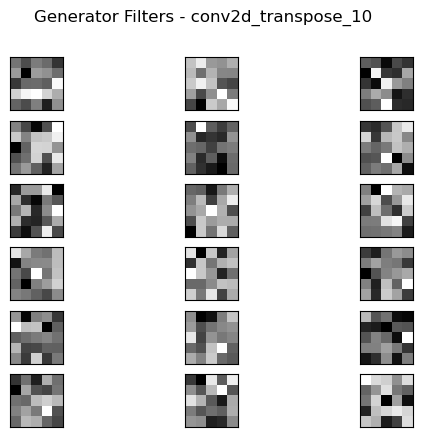

conv2d_transpose_11 (5, 5, 64, 128)


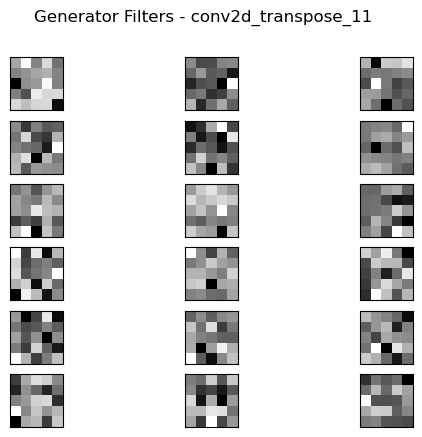

conv2d_16 (5, 5, 1, 64)


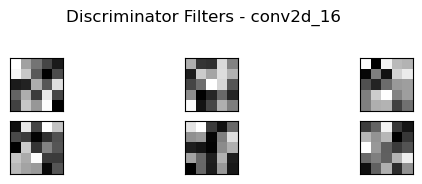

conv2d_17 (5, 5, 64, 128)


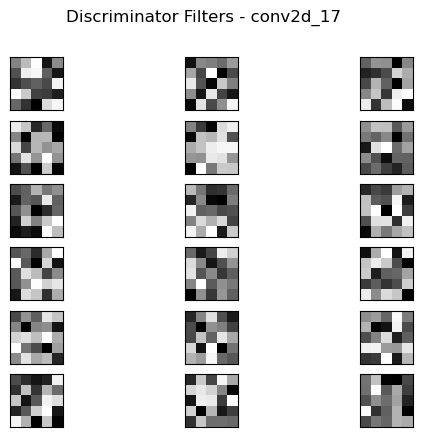

In [26]:
generator = build_generator()

# Visualize filters in the generator model
visualize_filters(generator, title_prefix='Generator Filters')

# build the discriminator model
discriminator = build_discriminator(28, 28, 1)

# Visualize filters in the discriminator model
visualize_filters(discriminator, title_prefix='Discriminator Filters')



In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

# Compile the model with optimizers and loss function
dcgan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

NUM_EPOCHS=10
# Create an instance of GANMonitor with the discriminator and generator models
gan_monitor = GANMonitor(num_img=16, latent_dim=LATENT_DIM, discriminator=discriminator, generator=generator)

# Train the DCGAN model
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[gan_monitor])


Epoch 1/10
 144/1875 [=>............................] - ETA: 4:00 - d_loss: 0.6757 - g_loss: 0.8031

conv2d_transpose_10 (5, 5, 128, 256)


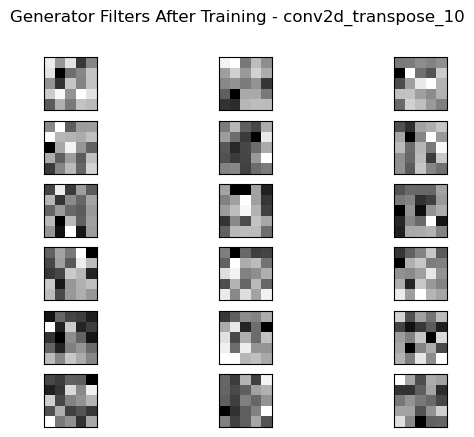

conv2d_transpose_11 (5, 5, 64, 128)


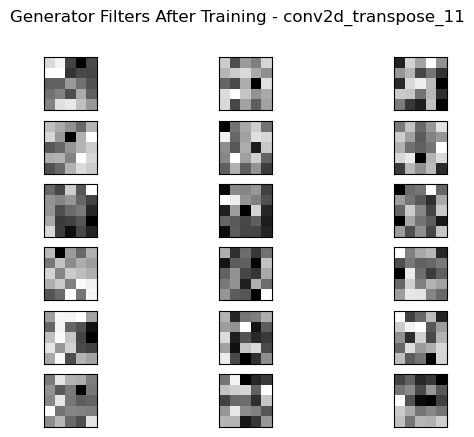

conv2d_16 (5, 5, 1, 64)


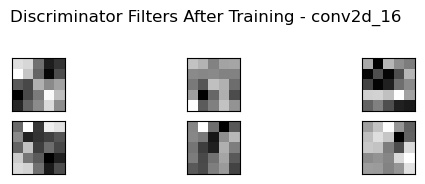

conv2d_17 (5, 5, 64, 128)


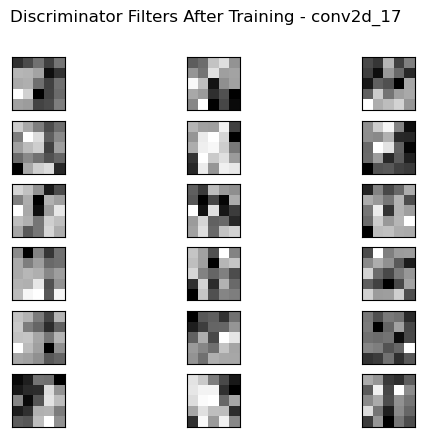

In [28]:
visualize_filters(generator, title_prefix='Generator Filters After Training')
visualize_filters(discriminator, title_prefix='Discriminator Filters After Training')